# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Runge-Kutta-methods-for-ODE-integration-in-Python" data-toc-modified-id="Runge-Kutta-methods-for-ODE-integration-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Runge-Kutta methods for ODE integration in Python</a></div><div class="lev2 toc-item"><a href="#Preliminary" data-toc-modified-id="Preliminary-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preliminary</a></div><div class="lev2 toc-item"><a href="#Runge-Kutta-method-of-order-1,-or-the-Euler-method" data-toc-modified-id="Runge-Kutta-method-of-order-1,-or-the-Euler-method-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Runge-Kutta method of order 1, or the Euler method</a></div><div class="lev2 toc-item"><a href="#Runge-Kutta-method-of-order-2" data-toc-modified-id="Runge-Kutta-method-of-order-2-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Runge-Kutta method of order 2</a></div><div class="lev2 toc-item"><a href="#Runge-Kutta-method-of-order-4,-&quot;RK4&quot;" data-toc-modified-id="Runge-Kutta-method-of-order-4,-&quot;RK4&quot;-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Runge-Kutta method of order 4, <em>"RK4"</em></a></div><div class="lev2 toc-item"><a href="#Comparisons" data-toc-modified-id="Comparisons-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Comparisons</a></div><div class="lev2 toc-item"><a href="#Comparisons-on-another-integration-problem" data-toc-modified-id="Comparisons-on-another-integration-problem-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Comparisons on another integration problem</a></div><div class="lev2 toc-item"><a href="#Small-benchmark" data-toc-modified-id="Small-benchmark-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Small benchmark</a></div><div class="lev2 toc-item"><a href="#Conclusion" data-toc-modified-id="Conclusion-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Conclusion</a></div>

# Runge-Kutta methods for ODE integration in Python

- I want to implement and illustrate the [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (actually, different variants), in the [Python programming language](https://www.python.org/).

- The Runge-Kutta methods are a family of numerical iterative algorithms to approximate solutions of [Ordinary Differential Equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation). I will simply implement them, for the mathematical descriptions, I let the interested reader refer to the Wikipedia page, or [any](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#References) [good](https://www.directtextbook.com/isbn/9780521007948) [book](https://www.decitre.fr/livres/analyse-numerique-et-equations-differentielles-9782868838919.html) or [course](https://courses.maths.ox.ac.uk/node/4294) on numerical integration of ODE.
- I will start with the order 1 method, then the order 2 and the most famous order 4.
- They will be compared on different ODE.

## Preliminary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext watermark
%watermark

2017-11-23T19:18:23+01:00

CPython 3.6.3
IPython 6.2.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-16-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
from scipy.integrate import odeint  # for comparison

I will use as a first example the one included in [the scipy documentation for this `odeint` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

$$\theta''(t) + b \theta'(t) + c \sin(\theta(t)) = 0.$$

If $\omega(t) = \theta'(t)$, this gives
$$ \begin{cases}
\theta'(t) = \omega(t) \\
\omega'(t) = -b \omega(t) - c \sin(\theta(t))
\end{cases} $$

Vectorially, if $y(t) = [\theta(t), \omega(t)]$, then the equation is $y' = f(t, y)$ where $f(t, y) = [y_2(t), -b y_2(t) - c \sin(y_1(t))]$.

In [3]:
def pend(y, t, b, c):
    return np.array([y[1], -b*y[1] - c*np.sin(y[0])])

We assume the values of $b$ and $c$ to be known, and the starting point to be also fixed:

In [44]:
b = 0.25
c = 5.0
y0 = np.array([np.pi - 0.1, 0.0])

The `odeint` function will be used to solve this ODE on the interval $t \in [0, 10]$, with $101$ points.

In [5]:
t = np.linspace(0, 10, 101)

It is used like this, and our implementations will follow this signature.

In [6]:
sol = odeint(pend, y0, t, args=(b, c))

Text(0.5,0,'t')

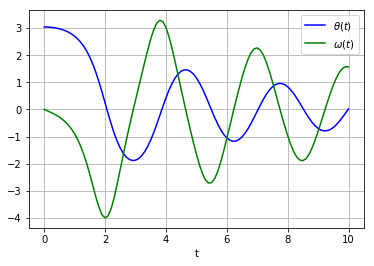

In [7]:
plt.plot(t, sol[:, 0], 'b', label=r'$\theta(t)$')
plt.plot(t, sol[:, 1], 'g', label=r'$\omega(t)$')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

----
## Runge-Kutta method of order 1, or the Euler method

The approximation is computed using this update:
$$y_{n+1} = y_n + (t_{n+1} - t_n) f(y_n, t_n).$$

The math behind this formula are the following: if $g$ is a solution to the ODE, and so far the approximation is correct, $y_n \simeq g(t_n)$, then a small step $h = t_{n+1} - t_n$ satisfy $g(t_n + h) \simeq g(t_n) + h g'(t_n) \simeq y_n + h f(g(t_n), t_n) + \simeq y_n + h f(y_n, t_n)$.

In [8]:
def rungekutta1(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        y[i+1] = y[i] + (t[i+1] - t[i]) * f(y[i], t[i], *args)
    return y

In [9]:
sol = rungekutta1(pend, y0, t, args=(b, c))

Text(0.5,0,'t')

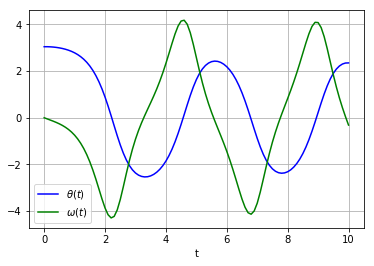

In [10]:
plt.plot(t, sol[:, 0], 'b', label=r'$\theta(t)$')
plt.plot(t, sol[:, 1], 'g', label=r'$\omega(t)$')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

With the same number of points, the Euler method (*i.e.* the Runge-Kutta method of order 1) is less precise than the reference `odeint` method. With more points, it can give a satisfactory approximation of the solution:

In [11]:
t2 = np.linspace(0, 10, 1001)
sol2 = rungekutta1(pend, y0, t2, args=(b, c))

In [12]:
t3 = np.linspace(0, 10, 10001)
sol3 = rungekutta1(pend, y0, t3, args=(b, c))

Text(0.5,0,'t')

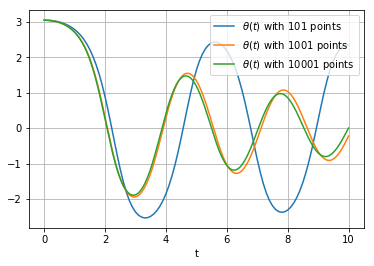

In [13]:
plt.plot(t, sol[:, 0], label=r'$\theta(t)$ with 101 points')
plt.plot(t2, sol2[:, 0], label=r'$\theta(t)$ with 1001 points')
plt.plot(t3, sol3[:, 0], label=r'$\theta(t)$ with 10001 points')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

----
## Runge-Kutta method of order 2

The order 2 Runge-Method uses this update:
$$ y_{n+1} = y_n + h f(t + \frac{h}{2}, y_n + \frac{h}{2} f(t, y_n)),$$
if $h = t_{n+1} - t_n$.

In [14]:
def rungekutta2(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        y[i+1] = y[i] + h * f(y[i] + f(y[i], t[i], *args) * h / 2., t[i] + h / 2., *args)
    return y

For our simple ODE example, this method is already quite efficient.

In [15]:
t4 = np.linspace(0, 10, 21)
sol4 = rungekutta2(pend, y0, t4, args=(b, c))

In [16]:
t = np.linspace(0, 10, 101)
sol = rungekutta2(pend, y0, t, args=(b, c))

In [17]:
t2 = np.linspace(0, 10, 1001)
sol2 = rungekutta2(pend, y0, t2, args=(b, c))

In [18]:
t3 = np.linspace(0, 10, 10001)
sol3 = rungekutta2(pend, y0, t3, args=(b, c))

Text(0.5,0,'t')

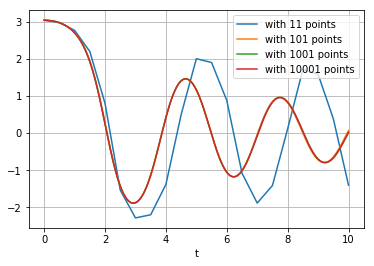

In [19]:
plt.plot(t4, sol4[:, 0], label='with 11 points')
plt.plot(t, sol[:, 0], label='with 101 points')
plt.plot(t2, sol2[:, 0], label='with 1001 points')
plt.plot(t3, sol3[:, 0], label='with 10001 points')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

----
## Runge-Kutta method of order 4, *"RK4"*

The order 4 Runge-Method uses this update:
$$ y_{n+1} = y_n + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4),$$
if $h = t_{n+1} - t_n$, and
$$\begin{cases}
k_1 &= f(y_n, t_n), \\
k_2 &= f(y_n + \frac{h}{2} k_1, t_n + \frac{h}{2}), \\
k_3 &= f(y_n + \frac{h}{2} k_2, t_n + \frac{h}{2}), \\
k_4 &= f(y_n + h k_3, t_n + h).
\end{cases}$$

In [20]:
def rungekutta4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y

For our simple ODE example, this method is even more efficient.

In [21]:
t4 = np.linspace(0, 10, 21)
sol4 = rungekutta4(pend, y0, t4, args=(b, c))

In [22]:
t = np.linspace(0, 10, 101)
sol = rungekutta4(pend, y0, t, args=(b, c))

In [23]:
t2 = np.linspace(0, 10, 1001)
sol2 = rungekutta4(pend, y0, t2, args=(b, c))

Text(0.5,0,'t')

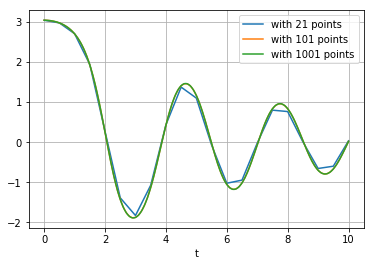

In [24]:
plt.plot(t4, sol4[:, 0], label='with 21 points')
plt.plot(t, sol[:, 0], label='with 101 points')
plt.plot(t2, sol2[:, 0], label='with 1001 points')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

I also want to try to speed this function up by using [numba](http://numba.pydata.org/).

In [45]:
from numba import jit

In [46]:
@jit
def rungekutta4_jit(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y

Both versions compute the same thing.

In [53]:
t2 = np.linspace(0, 10, 1001)
sol2 = rungekutta4(pend, y0, t2, args=(b, c))
sol2_jit = rungekutta4_jit(pend, y0, t2, args=(b, c))
np.linalg.norm(sol2 - sol2_jit)

0.0

----
## Comparisons

In [25]:
methods = [odeint, rungekutta1, rungekutta2, rungekutta4]
markers = ['+', 'o', 's', '>']

In [26]:
def test_1(n=101):
    t = np.linspace(0, 10, n)
    for method, m in zip(methods, markers):
        sol = method(pend, y0, t, args=(b, c))
        plt.plot(t, sol[:, 0], label=method.__name__, marker=m)
    plt.legend(loc='best')
    plt.title("Comparison of different ODE integration methods for $n={}$ points".format(n))
    plt.xlabel("$t = [0, 10]$")
    plt.grid()
    plt.show()

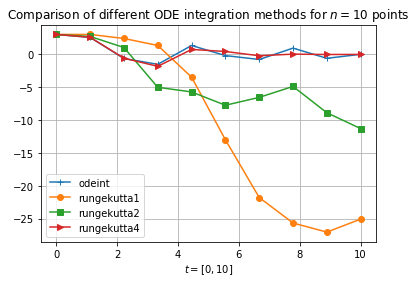

In [27]:
test_1(10)

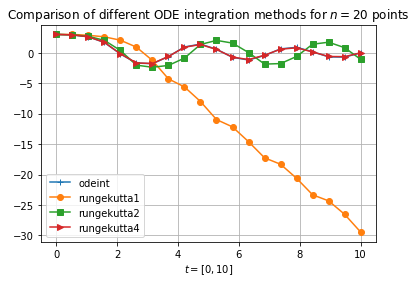

In [28]:
test_1(20)

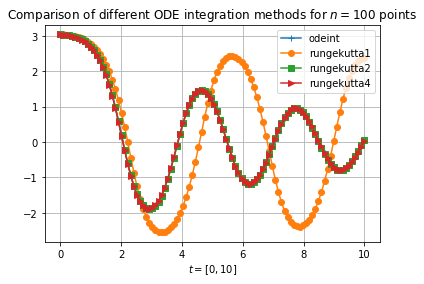

In [29]:
test_1(100)

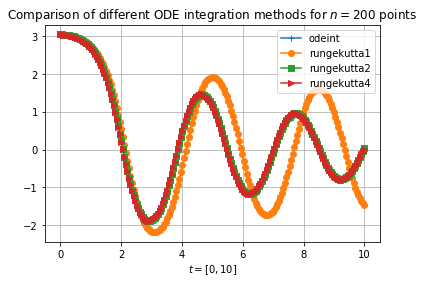

In [30]:
test_1(200)

## Comparisons on another integration problem

Consider the following ODE on $t\in[0, 1]$:
$$
\begin{cases}
 y'''(t) = 12 y(t)^{4/5} + \cos(y'(t))^3 - \sin(y''(t)) \\
 y(0) = 0, y'(0) = 1, y''(0) = 0.1
\end{cases}
$$

It can be written in a vectorial form like the first one:

In [31]:
def f(y, t):
    return np.array([y[1], y[2], 12 * y[0] ** (4/5.) + np.cos(y[1])**3 - np.sin(y[2])])

In [32]:
def test_2(n=101):
    t = np.linspace(0, 1, n)
    y0 = np.array([0, 1, 0.1])
    for method, m in zip(methods, markers):
        sol = method(f, y0, t)
        plt.plot(t, sol[:, 0], label=method.__name__, marker=m)
    plt.legend(loc='best')
    plt.title("Comparison of different ODE integration methods for $n={}$ points".format(n))
    plt.xlabel("$t = [0, 1]$")
    plt.grid()
    plt.show()

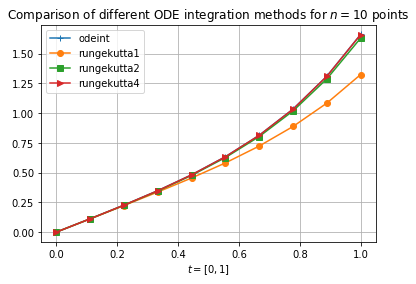

In [33]:
test_2(10)

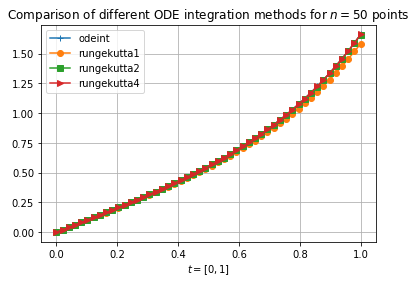

In [34]:
test_2(50)

Consider the following ODE on $t\in[0, 3]$:
$$
\begin{cases}
 y''''(t) = y(t)^{-5/3} \\
 y(0) = 10, y'(0) = -3, y''(0) = 1, y'''(0) = 1
\end{cases}
$$

It can be written in a vectorial form like the first one:

In [35]:
def f(y, t):
    return np.array([y[1], y[2], y[3], y[0]**(-5/3.)])

In [36]:
def test_3(n=101):
    t = np.linspace(0, 3, n)
    y0 = np.array([10, -3, 1, 1])
    for method, m in zip(methods, markers):
        sol = method(f, y0, t)
        plt.plot(t, sol[:, 0], label=method.__name__, marker=m)
    plt.legend(loc='best')
    plt.title("Comparison of different ODE integration methods for $n={}$ points".format(n))
    plt.xlabel("$t = [0, 1]$")
    plt.grid()
    plt.show()

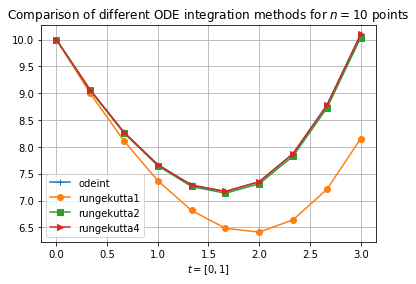

In [37]:
test_3(10)

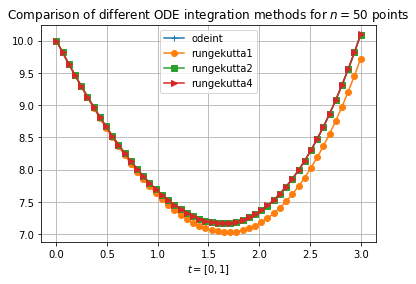

In [38]:
test_3(50)

Our hand-written Runge-Kutta method of order 4 seems to be as efficient as the `odeint` method from `scipy`... and that's because `odeint` basically uses a Runge-Kutta method of order 4 (with smart variants).

## Small benchmark
We can also compare their speed:

In [54]:
methods = [odeint, rungekutta1, rungekutta2, rungekutta4, rungekutta4_jit]

y0 = np.array([10, -3, 1, 1])
for n in [20, 100, 1000]:
    print("\n")
    t = np.linspace(0, 3, n)
    for method in methods:
        print("Time of solving this ODE for {} points with {} method...".format(n, method.__name__))
        %timeit sol = method(f, y0, t)



Time of solving this ODE for 20 points with odeint method...
212 µs ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time of solving this ODE for 20 points with rungekutta1 method...
114 µs ± 5.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Time of solving this ODE for 20 points with rungekutta2 method...
223 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time of solving this ODE for 20 points with rungekutta4 method...
482 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time of solving this ODE for 20 points with rungekutta4_jit method...
896 µs ± 61.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Time of solving this ODE for 100 points with odeint method...
222 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time of solving this ODE for 100 points with rungekutta1 method...
548 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Time of solving this ODE for 100 points

- Well, that's disappointing, the Numba Jit version was NOT faster than the manual implementation...
- The order 1 method is simpler and so faster than the order 2, which itself is simpler and faster than the order 4 method.
- And we can check that the SciPy implementation is much faster than our manual implentations!

## Conclusion

> *That's it for today, folks!* See my other notebooks, [available on GitHub](https://github.com/Naereen/notebooks/).